In [53]:
import pandas as pd 
import os
import datetime as dt
import matplotlib.pyplot as plt
import time
import sys
import seaborn as sns
import progressbar
import warnings
import ast
from prophet import Prophet
warnings.filterwarnings('ignore')


Importing plotly failed. Interactive plots will not work.


In [2]:
str(dt.date.today())

'2025-09-15'

In [3]:
def getDataFrame ():
    #url = "https://raw.githubusercontent.com/EduHdzVillasana/COVIDSTATSMX/master/Datos%20Abiertos"
    url = "../../../../COVIDSTATSMX/Datos Abiertos"
    # Geting the file´s name YYMMDDCOVID19MEXICO.csv
    td = dt.date.today()
    date = '2022-07-22'
    sufix = "COVID19MEXICO.csv"
    covid_df = pd.read_csv(url+"/220722COVID19MEXICO.csv")

    return covid_df, date

In [4]:
# Get a list with dates YYYY-MM-DD
def getDateList (today_s):
    i = dt.date(2020,1,1) # Covid cases register starts on Junuary First 2020
    today_l = today_s.split('-')
    td = dt.date(int(today_l[0]),int(today_l[1]),int(today_l[2]))
    p_date = str(i.year)+"-"+"0"+str(i.month)+"-"+"0"+str(i.day)
    dates = [p_date]

    while i != td:
        i += dt.timedelta(days = 1)
        if (i.month < 10):
            month = "0"+str(i.month)
        else:
            month = str(i.month)
        
        if (i.day < 10):
            day = "0"+str(i.day)
        else:
            day = str(i.day)

        p_date = str(i.year) + "-" + month + "-" + day
        dates.append(p_date)
    return dates

In [44]:
def filter_by_zm (covid_df, zm_dict):
    df_codes = pd.DataFrame([(k, v) for k, values in zm_dict.items() for v in values], 
                  columns=["Estado", "Municipio"])
    # 'ENTIDAD_RES', 'MUNICIPIO_RES'
    df_codes["Estado"] = df_codes["Estado"].astype(int)
    df_codes["Municipio"] = df_codes["Municipio"].astype(int)
    df_filtered = covid_df.merge(df_codes, how = "inner",
                                 left_on = ['ENTIDAD_RES', 'MUNICIPIO_RES'],
                                 right_on = ["Estado", "Municipio"])
    
    df_filtered = df_filtered.drop(columns = ["Estado", "Municipio"])

    return df_filtered
    

In [5]:
# Filter the data and get a dict with the cases registraded by day
# There is an option where the state and county can be specified
def getCasesByDay (covid_df, dates, state = 0, countys = []):
    casesBD = {} # it will be changed to data frame

    covid_df = covid_df[["FECHA_SINTOMAS", "RESULTADO","FECHA_DEF", "HOSPITALIZADO"]][((covid_df["ENTIDAD_RES"] == state)
    |( state == 0)) 
    & ((covid_df["MUNICIPIO_RES"].isin (countys)) 
    | (len(countys) == 0))]

    casesBD ["FECHA"] = []
    casesBD ["CASOS_POSITIVOS"] = []
    casesBD ["CASOS_NEGATIVOS"] = []
    casesBD ["CASOS_SOSPECHOSOS"] = []
    casesBD ["DEFUNCIONES"] = []
    casesBD ["HOSPITALIZACIONES"] = []
    casesBD ["FECHA"] = dates
    #totalCases = len(covid_df)

    # Get Pandas series of cases using groupby
    positivesBD = covid_df[covid_df["RESULTADO"] == 1].groupby(["FECHA_SINTOMAS","RESULTADO"])["RESULTADO"].count()
    negativesBD = covid_df[covid_df["RESULTADO"] == 2].groupby(["FECHA_SINTOMAS","RESULTADO"])["RESULTADO"].count()
    suspectedsBD = covid_df[covid_df["RESULTADO"] == 3].groupby(["FECHA_SINTOMAS","RESULTADO"])["RESULTADO"].count()
    deceasedsBD = covid_df[(covid_df["RESULTADO"] == 1) & (covid_df["FECHA_DEF"] != "9999-99-99") ].groupby(["FECHA_DEF","RESULTADO"])["RESULTADO"].count()
    hospitalizedBD = covid_df[(covid_df["HOSPITALIZADO"] == 1) & (covid_df["RESULTADO"] == 1)].groupby(["FECHA_SINTOMAS","RESULTADO"])["RESULTADO"].count()

    # The data is filtered and positive cases, negative cases, suspicius cases and confirmed deaths for each day are count
    # For positive, negative and suspicious cases the column "FECHA" represents the day when the symptoms started,
    # while for deaths, it represent the date of death
    # It should not be forgotten that only cold numbers are shown here, but each one of the deaths represents a life lost.

    for date in casesBD["FECHA"]:

        try:
            pos = int(positivesBD[date])
        except:
            pos = 0
        
        try:
            neg = int(negativesBD[date])
        except:
            neg = 0
        
        try:
            sus = int(suspectedsBD[date])
        except:
            sus = 0
        
        try:
            dec = int(deceasedsBD[date])
        except:
            dec = 0

        try:
            hos = int(hospitalizedBD[date])
        except:
            hos = 0

        casesBD["CASOS_POSITIVOS"].append(pos)
        casesBD["CASOS_NEGATIVOS"].append(neg)
        casesBD["CASOS_SOSPECHOSOS"].append(sus)
        casesBD["DEFUNCIONES"].append(dec)
        casesBD["HOSPITALIZACIONES"].append(hos)
    return casesBD

In [6]:
def createGraph (name, casesBD_df, date):
    casesBD_df["FECHA"] = pd.to_datetime(casesBD_df["FECHA"], format = "%Y-%m-%d")
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot()
    sns.lineplot(x = casesBD_df["FECHA"], y = casesBD_df["CASOS_POSITIVOS"], label = "Casos Positivos", color = "r", ax = ax)
    sns.lineplot(x = casesBD_df["FECHA"], y = casesBD_df["DEFUNCIONES"], label = "Defunciones", color = "b", ax = ax)
    sns.lineplot(x = casesBD_df["FECHA"], y = casesBD_df["CASOS_SOSPECHOSOS"], label = "Casos Sospechosos", color = "g", ax = ax)
    ax.set_title(f"GRAFICA {name} {date}")
    ax.set_ylabel("CASOS")
    plt.savefig("Graficas/" + name +" " + date + ".png")


def createGraph_ (name, casesBD_df, date):
    casesBD_df["FECHA"] = pd.to_datetime(casesBD_df["FECHA"], format = "%Y-%m-%d")
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot()
    sns.lineplot(x = casesBD_df["FECHA"], y = casesBD_df["CASOS_POSITIVOS"], label = "Casos Positivos", color = "r", ax = ax)
    sns.lineplot(x = casesBD_df["FECHA"], y = casesBD_df["DEFUNCIONES"], label = "Defunciones", color = "b", ax = ax)
    sns.lineplot(x = casesBD_df["FECHA"], y = casesBD_df["CASOS_SOSPECHOSOS"], label = "Casos Sospechosos", color = "g", ax = ax)
    ax.set_title(f"GRAFICA {name} {date}")

In [7]:
def getResult (cl):
    positive = [1,2,3]
    negative = [7]
    #suspicious = 6

    if (cl in positive):
        return 1
    elif (cl in negative):
        return 2
    else:
        return 3

#### Prophet Functions

In [54]:
def prepare_data_for_prophet(df, date_col='date', value_col='value'):
    """
    Prepare DataFrame for Prophet by renaming columns and ensuring proper data types
    
    Parameters:
    df (DataFrame): Input DataFrame
    date_col (str): Name of the date column
    value_col (str): Name of the value column
    
    Returns:
    DataFrame: Prepared DataFrame for Prophet
    """
    prophet_df = df[[date_col, value_col]].copy()
    prophet_df.columns = ['ds', 'y']
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])
    return prophet_df

In [68]:
def validate_data_for_prophet(df):
    """
    Validate DataFrame for Prophet requirements
    
    Parameters:
    df (DataFrame): Prophet-formatted DataFrame
    
    Returns:
    bool: True if data is valid, raises exception otherwise
    """
    # Check required columns
    if 'ds' not in df.columns or 'y' not in df.columns:
        raise ValueError("DataFrame must have 'ds' and 'y' columns")
    
    # Check for empty DataFrame
    if len(df) == 0:
        raise ValueError("DataFrame is empty")
    
    # Check for missing values
    if df['ds'].isnull().any():
        raise ValueError("Missing values found in 'ds' column")
    
    if df['y'].isnull().any():
        print(f"Warning: {df['y'].isnull().sum()} missing values found in 'y' column")
        print("Prophet can handle missing values, but consider imputing them if needed")
    
    # Check data types
    if not pd.api.types.is_datetime64_any_dtype(df['ds']):
        raise ValueError("'ds' column must be datetime type")
    
    if not pd.api.types.is_numeric_dtype(df['y']):
        raise ValueError("'y' column must be numeric type")
    
    # Check minimum data points
    if len(df) < 10:
        raise ValueError("Prophet requires at least 10 data points")
    
    print(f"Data validation passed: {len(df)} data points from {df['ds'].min()} to {df['ds'].max()}")
    return True

In [71]:
def fit_prophet_model(df, **prophet_params):
    """
    Fit Prophet model to the data
    
    Parameters:
    df (DataFrame): Prophet-formatted DataFrame
    **prophet_params: Additional parameters for Prophet model
    
    Returns:
    tuple: (fitted_model, forecast_dataframe, components_dataframe)
    """
    # Default Prophet parameters
    default_params = {
        'yearly_seasonality': True,
        'weekly_seasonality': True,
        'daily_seasonality': False,
        'seasonality_mode': 'additive',
        'changepoint_prior_scale': 0.05
    }

    # Update with user-provided parameters
    default_params.update(prophet_params)
    
    # Initialize and fit model
    model = Prophet(**default_params)
    print("Fitting Prophet model...")
    model.fit(df)
    
    # Create predictions for existing data
    components = model.predict(df)
    
    # Create future dataframe for forecasting
    future = model.make_future_dataframe(periods=90)
    forecast = model.predict(future)
    
    return model, forecast, components

In [56]:
def create_decomposition_dataframe(original_df, components_df):
    """
    Create DataFrame with decomposition components
    
    Parameters:
    original_df (DataFrame): Original Prophet-formatted data
    components_df (DataFrame): Prophet components predictions
    
    Returns:
    DataFrame: Decomposition results
    """
    decomposition = pd.DataFrame({
        'date': original_df['ds'],
        'original': original_df['y'],
        'trend': components_df['trend'],
        'yearly_seasonal': components_df['yearly'],
        'weekly_seasonal': components_df['weekly'],
        'residual': original_df['y'] - components_df['yhat']
    })
    return decomposition

In [57]:
def plot_decomposition(decomposition_df, figsize=(12, 15)):
    """
    Plot time series decomposition components
    
    Parameters:
    decomposition_df (DataFrame): Decomposition results DataFrame
    figsize (tuple): Figure size (width, height)
    
    Returns:
    matplotlib.figure.Figure: The created figure
    """
    fig, axes = plt.subplots(5, 1, figsize=figsize)
    fig.suptitle('Time Series Decomposition using Prophet', fontsize=16, fontweight='bold')

    # Define plot configurations
    plot_configs = [
        {'data': 'original', 'title': 'Original Time Series', 'color': 'black'},
        {'data': 'trend', 'title': 'Trend Component', 'color': 'blue'},
        {'data': 'yearly_seasonal', 'title': 'Yearly Seasonal Component', 'color': 'green'},
        {'data': 'weekly_seasonal', 'title': 'Weekly Seasonal Component', 'color': 'orange'},
        {'data': 'residual', 'title': 'Residuals', 'color': 'red'}
    ]
    
    for i, config in enumerate(plot_configs):
        axes[i].plot(decomposition_df['date'], decomposition_df[config['data']], 
                    color=config['color'], linewidth=1 if i != 1 else 2)
        axes[i].set_title(config['title'])
        axes[i].set_ylabel(config['title'].split()[0])
        axes[i].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Date')
    plt.tight_layout()
    return fig

##### Extra Functions

In [58]:
def plot_component_contributions(decomposition_df, figsize=(10, 6)):
    """
    Plot the contribution of each component to total variance
    
    Parameters:
    decomposition_df (DataFrame): Decomposition results DataFrame
    figsize (tuple): Figure size (width, height)
    
    Returns:
    matplotlib.figure.Figure: The created figure
    """
    # Calculate contributions
    total_variation = decomposition_df['original'].var()
    contributions = {
        'Trend': decomposition_df['trend'].var() / total_variation * 100,
        'Yearly Seasonal': decomposition_df['yearly_seasonal'].var() / total_variation * 100,
        'Weekly Seasonal': decomposition_df['weekly_seasonal'].var() / total_variation * 100,
        'Residual': decomposition_df['residual'].var() / total_variation * 100
    }
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=figsize)
    components = list(contributions.keys())
    values = list(contributions.values())
    colors = ['blue', 'green', 'orange', 'red']
    
    bars = ax.bar(components, values, color=colors, alpha=0.7)
    ax.set_title('Component Contribution to Total Variance')
    ax.set_ylabel('Contribution (%)')
    ax.set_xlabel('Components')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{value:.1f}%', ha='center', va='bottom')
    
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    return fig

In [59]:
def print_decomposition_summary(decomposition_df):
    """
    Print summary statistics of the decomposition
    
    Parameters:
    decomposition_df (DataFrame): Decomposition results DataFrame
    """
    print("\nTime Series Decomposition Summary:")
    print("=" * 40)
    print(f"Data points: {len(decomposition_df)}")
    print(f"Date range: {decomposition_df['date'].min()} to {decomposition_df['date'].max()}")
    
    print("\nComponent Statistics:")
    print(f"Trend range: {decomposition_df['trend'].min():.2f} to {decomposition_df['trend'].max():.2f}")
    print(f"Yearly seasonal range: {decomposition_df['yearly_seasonal'].min():.2f} to {decomposition_df['yearly_seasonal'].max():.2f}")
    print(f"Weekly seasonal range: {decomposition_df['weekly_seasonal'].min():.2f} to {decomposition_df['weekly_seasonal'].max():.2f}")
    print(f"Residual std: {decomposition_df['residual'].std():.2f}")

In [60]:
def print_component_analysis(decomposition_df):
    """
    Print detailed component contribution analysis
    
    Parameters:
    decomposition_df (DataFrame): Decomposition results DataFrame
    """
    print("\nComponent Contribution Analysis:")
    print("=" * 40)
    total_variation = decomposition_df['original'].var()
    
    contributions = {
        'Trend': decomposition_df['trend'].var() / total_variation * 100,
        'Yearly seasonal': decomposition_df['yearly_seasonal'].var() / total_variation * 100,
        'Weekly seasonal': decomposition_df['weekly_seasonal'].var() / total_variation * 100,
        'Residual': decomposition_df['residual'].var() / total_variation * 100
    }
    
    for component, contribution in contributions.items():
        print(f"{component} contribution to variance: {contribution:.1f}%")

In [14]:
df_ZM = pd.read_excel("Diccionario Municipios.xlsx").fillna("")

In [16]:
df_ZM = df_ZM[df_ZM["Codigos de Dataset"] != ""]

In [17]:
df_ZM["Codigos de Dataset"] = df_ZM["Codigos de Dataset"].apply(ast.literal_eval)

In [25]:
mty_codes = df_ZM[df_ZM["Nombre"] == "Zona metropolitana de Monterrey"]["Codigos de Dataset"].iloc[0]

In [29]:
# Getting the data and preparing it
covid_df, update_date = getDataFrame()
dates = getDateList(update_date)
covid_df["RESULTADO"] = covid_df["CLASIFICACION_FINAL"].apply(getResult)
covid_df["HOSPITALIZADO"] = covid_df["TIPO_PACIENTE"].apply(lambda x: 1 if x == 2 else 0)

In [30]:
casesBD_dict = getCasesByDay(covid_df, dates)
casesBD_df = pd.DataFrame(casesBD_dict)

In [31]:
casesBD_df

,FECHA,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,HOSPITALIZACIONES
0,2020-01-01,0,133,154,0,0
1,2020-01-02,0,102,131,0,0
2,2020-01-03,0,116,131,0,0
3,2020-01-04,0,124,121,0,0
4,2020-01-05,0,171,178,0,0
...,...,...,...,...,...,...
929,2022-07-18,17679,8493,1746,61,377
930,2022-07-19,11290,5922,1521,50,223
931,2022-07-20,5448,3469,1035,50,132
932,2022-07-21,1008,845,292,13,38


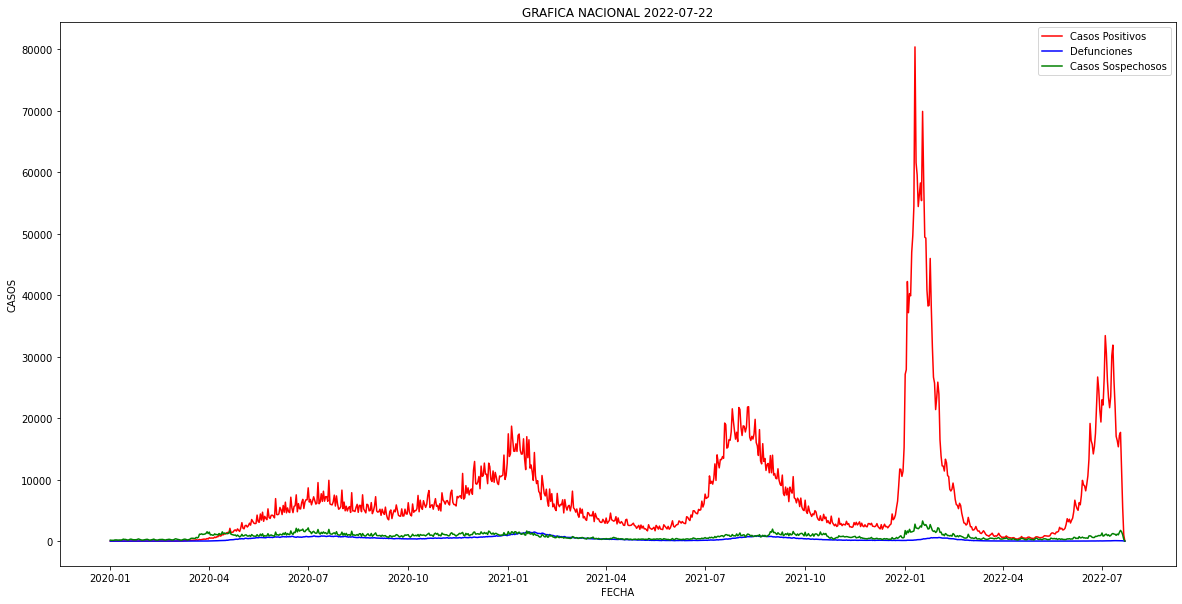

In [33]:
createGraph("NACIONAL", casesBD_df, update_date)

In [46]:
covid_df["FECHA_SINTOMAS"]

0           2020-07-20
1           2021-02-20
2           2020-08-17
3           2020-03-05
4           2020-12-28
               ...    
17410392    2022-07-20
17410393    2022-07-20
17410394    2022-07-20
17410395    2022-07-20
17410396    2022-07-20
Name: FECHA_SINTOMAS, Length: 17410397, dtype: object

In [35]:
covid_df.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_LAB',
       'TOMA_MUESTRA_ANTIGENO', 'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI', 'RESULTADO',
       'HOSPITALIZADO'],
      dtype='object')

### Ideas

* Separar por 10 Areas Metropolitanas (Cd Victoria, Monterrey, ZMVM)
* Obtener datos a nivel de Municipio (Densidad)
* Graficas de Areas con datos 
* Sarimax <- Variables externas
* Prohet
* LSTM
* Grading Boosting (Modelo regresor)
* Shap ()
* TSAI <- Libreria con modelos de time serties no tan comunes

In [36]:
casesBD_df

,FECHA,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,HOSPITALIZACIONES
0,2020-01-01,0,133,154,0,0
1,2020-01-02,0,102,131,0,0
2,2020-01-03,0,116,131,0,0
3,2020-01-04,0,124,121,0,0
4,2020-01-05,0,171,178,0,0
...,...,...,...,...,...,...
929,2022-07-18,17679,8493,1746,61,377
930,2022-07-19,11290,5922,1521,50,223
931,2022-07-20,5448,3469,1035,50,132
932,2022-07-21,1008,845,292,13,38


In [47]:
casesBD_df.sum()

CASOS_POSITIVOS       6588854
CASOS_NEGATIVOS      10075536
CASOS_SOSPECHOSOS      746007
DEFUNCIONES            326968
HOSPITALIZACIONES      697305
dtype: int64

### Analisis de la Zona Metropolitana de Monterrey

In [49]:
mty_codes

{'19': ['006',
  '009',
  '010',
  '012',
  '018',
  '019',
  '021',
  '025',
  '026',
  '031',
  '039',
  '041',
  '045',
  '046',
  '048',
  '049']}

In [51]:
mty_df = filter_by_zm(covid_df, mty_codes)

In [52]:
mty_df.shape

(705152, 42)

In [61]:
cases_mty_dict = getCasesByDay(mty_df, dates)
cases_mty_df = pd.DataFrame(cases_mty_dict)

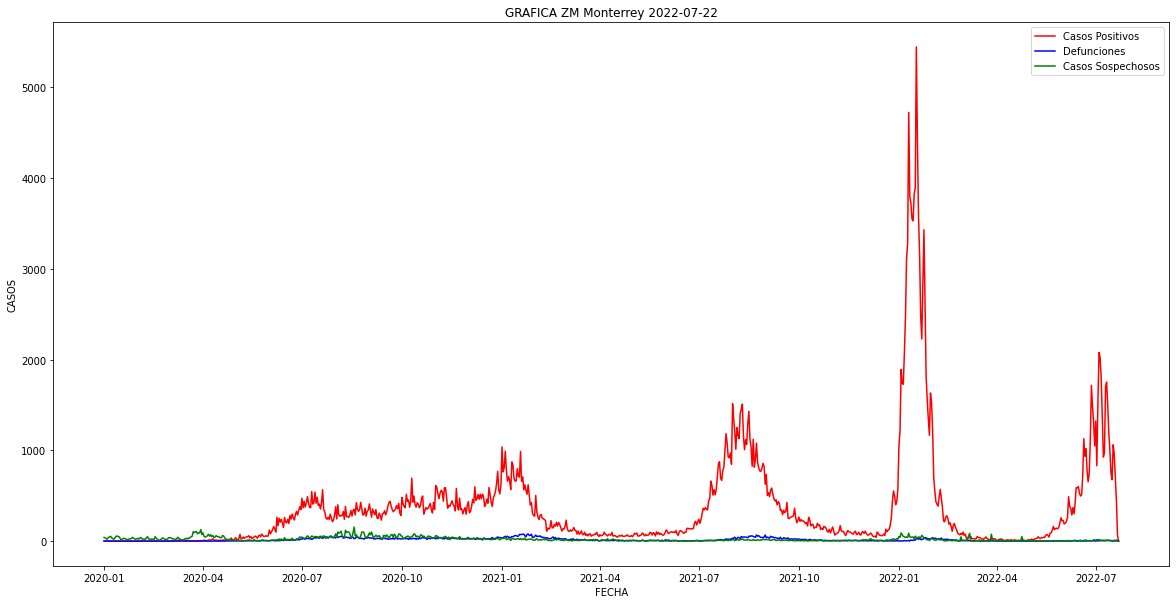

In [63]:
createGraph("ZM Monterrey", cases_mty_df, update_date)

In [64]:
cases_mty_df

,FECHA,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,HOSPITALIZACIONES
0,2020-01-01,0,5,40,0,0
1,2020-01-02,0,3,36,0,0
2,2020-01-03,0,1,25,0,0
3,2020-01-04,0,2,21,0,0
4,2020-01-05,0,4,42,0,0
...,...,...,...,...,...,...
929,2022-07-18,959,301,10,3,23
930,2022-07-19,705,218,5,1,21
931,2022-07-20,442,150,12,4,17
932,2022-07-21,62,22,8,0,7


### Descomposición de Serie de tiempo

In [65]:
prophet_df = prepare_data_for_prophet(cases_mty_df, 'FECHA', 'CASOS_POSITIVOS')

In [73]:
model, forecast, components = fit_prophet_model(prophet_df)

17:44:46 - cmdstanpy - INFO - Chain [1] start processing
17:44:46 - cmdstanpy - INFO - Chain [1] done processing


Fitting Prophet model...


In [74]:
decomposition = create_decomposition_dataframe(prophet_df, components)

In [75]:
print_decomposition_summary(decomposition)
print_component_analysis(decomposition)


Time Series Decomposition Summary:
Data points: 934
Date range: 2020-01-01 00:00:00 to 2022-07-22 00:00:00

Component Statistics:
Trend range: -552.80 to 660.96
Yearly seasonal range: -396.21 to 1342.97
Weekly seasonal range: -42.60 to 97.31
Residual std: 392.36

Component Contribution Analysis:
Trend contribution to variance: 15.7%
Yearly seasonal contribution to variance: 48.1%
Weekly seasonal contribution to variance: 0.6%
Residual contribution to variance: 45.5%


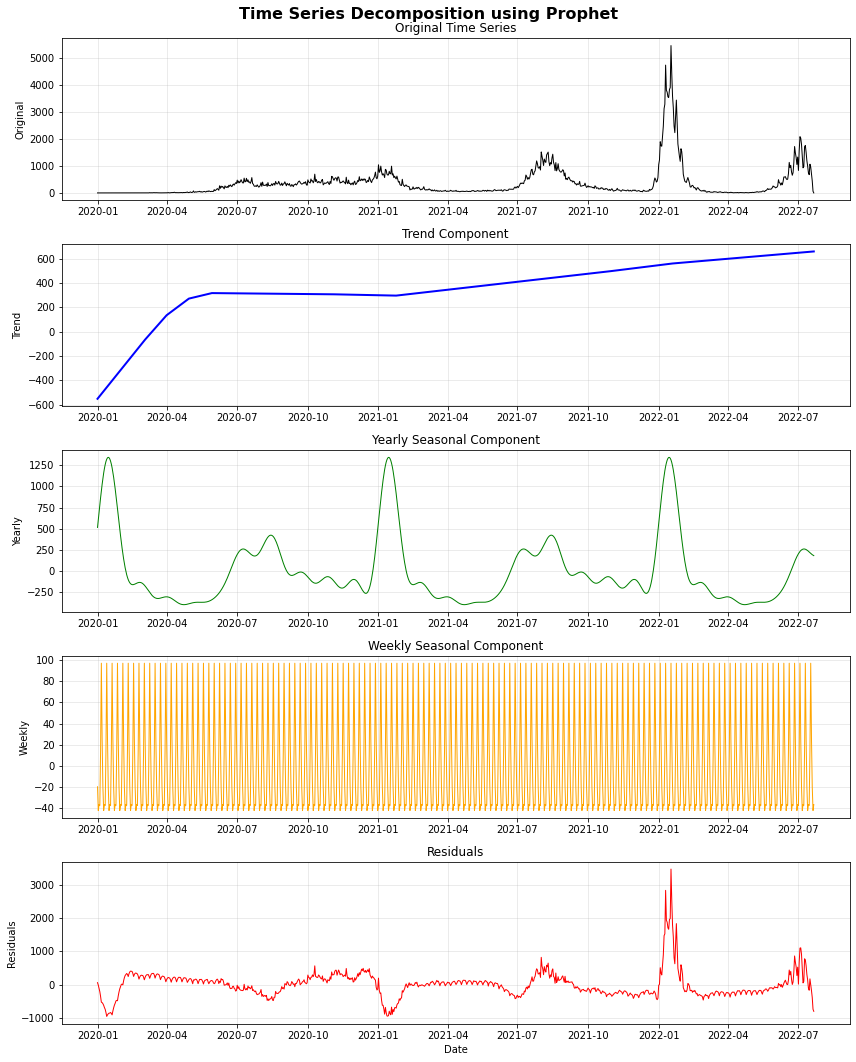

In [78]:
fig1 = plot_decomposition(decomposition)

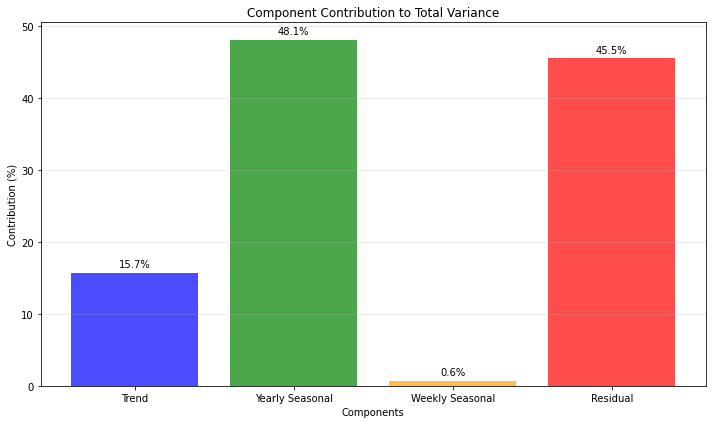

In [79]:
fig2 = plot_component_contributions(decomposition)